# Tanmay Garg
## CS20BTECH11063
## Deep Learning Assignment 5

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import math
import torch.functional as F
import torch.nn as nn
from sklearn.utils import shuffle
import PIL
from PIL import Image
# import cv2
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

np.random.seed(0)
torch.cuda.is_available()

/home/cs20btech11063/anaconda3/envs/gpu_env2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## MNIST Dataset

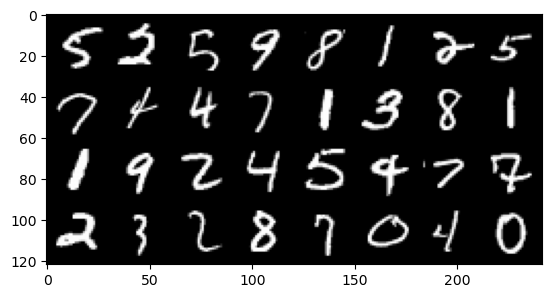

    5     2     5     9     8     1     2     5     7     4     4     7     1     3     8     1     1     9     2     4     5     4     7     7     2     3     2     8     7     0     4     0


In [2]:
# MNIST Dataset Loader

def get_mnist_data(batch_size=32, shuffle=True):
    transform = transforms.Compose([
                                    transforms.ToTensor(), 
                                ])
    
    train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
    
    return train_dataset, test_dataset, train_dataloader, test_dataloader

# Data Loader
train_ds, test_ds, train_dl, test_dl = get_mnist_data(batch_size=32, shuffle=True)


## Autoencoder

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(True),
            nn.Linear(128, hidden_dim),
            nn.ReLU(True)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 784),
            nn.Sigmoid()
            )     

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def train_model(self, train_loader, optimizer, criterion, device, epochs=10, lr=0.001):
        self.to(device)
        train_loss = []
        test_loss = []
        for epoch in range(epochs):
            train_loss.append(self.train_epoch(train_loader, optimizer, criterion, device))
        
        return train_loss, test_loss

    def train_epoch(self, train_loader, optimizer, criterion, device):
        train_loss = 0.0
        self.train()
        for batch_idx, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.view(inputs.size(0), -1)
            
            optimizer.zero_grad()
            outputs = self(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        
        return train_loss


==========Training AutoEncoder with hidden dimension = 32==========


Epoch: 1/10	 Train Loss: 0.029938	 Test Loss: 0.016673


Epoch: 2/10	 Train Loss: 0.014394	 Test Loss: 0.012221


Epoch: 3/10	 Train Loss: 0.011540	 Test Loss: 0.010527


Epoch: 4/10	 Train Loss: 0.010361	 Test Loss: 0.009609


Epoch: 5/10	 Train Loss: 0.009661	 Test Loss: 0.009109


Epoch: 6/10	 Train Loss: 0.009193	 Test Loss: 0.008741


Epoch: 7/10	 Train Loss: 0.008835	 Test Loss: 0.008394


Epoch: 8/10	 Train Loss: 0.008570	 Test Loss: 0.008243


Epoch: 9/10	 Train Loss: 0.008351	 Test Loss: 0.008099


Epoch: 10/10	 Train Loss: 0.008164	 Test Loss: 0.007912
==========Reconstruction of the images from the test set==========
Reconstructed Images:


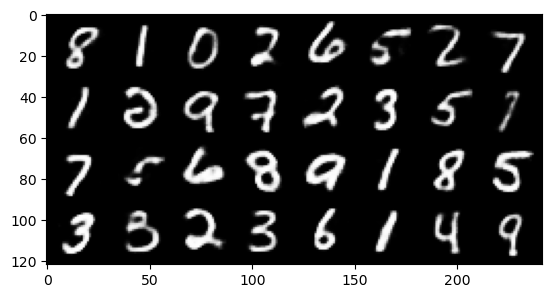

Original Images:


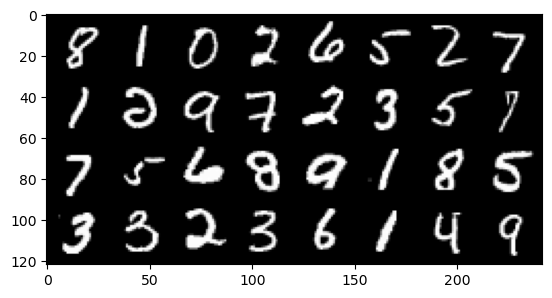

==========Reconstruction of the images from the train set==========
Reconstructed Images:


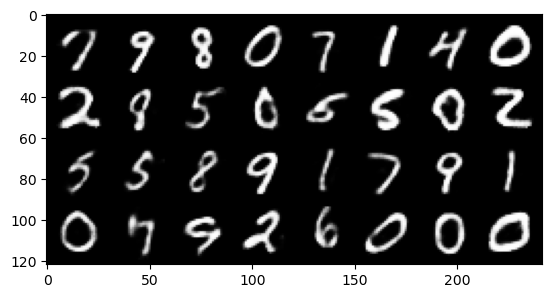

Original Images:


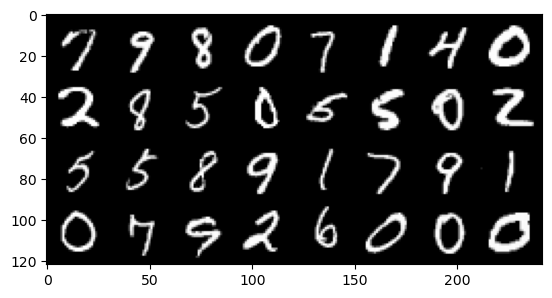

==========Reconstruction of the images from the latent space==========


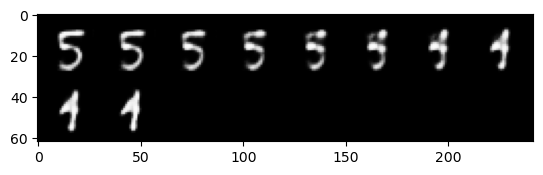

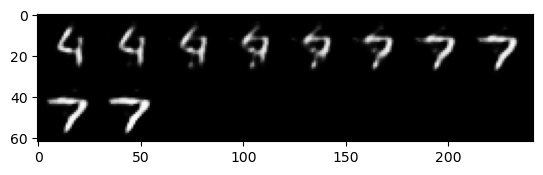

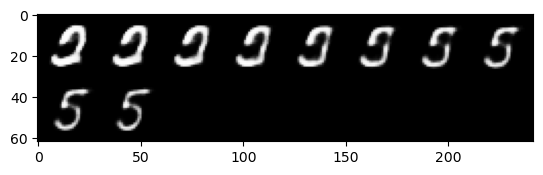

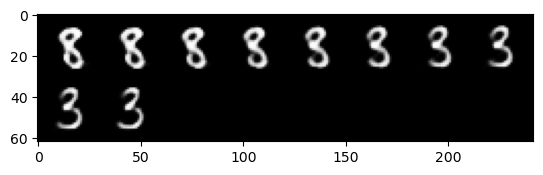

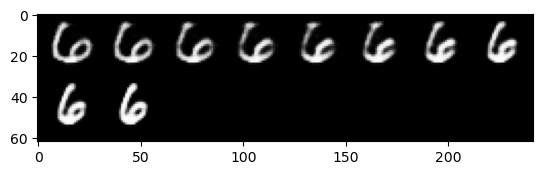

In [4]:
AutoEn_32  = AutoEncoder(hidden_dim=32)
optimizer = optim.Adam(AutoEn_32.parameters(), lr=0.001)
criterion = nn.MSELoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("==========Training AutoEncoder with hidden dimension = 32==========")
train_loss, test_loss = AutoEn_32.train_model(train_dl, test_dl, optimizer, criterion, device, epochs=10, lr=0.001)


## Variational Autoencoder

In [7]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super(VariationalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Sigmoid()    
            )
        
        self.fc_mu = nn.Linear(128, hidden_dim)
        # variance in log form
        self.fc_var = nn.Linear(128, hidden_dim)
        
    def sampling_method(self, mu, var):
        std = torch.exp(0.5 * var)
        # eps = torch.randn_like(std)
        # diff = 
        # print(mu, std)
        return mu + torch.randn(std.size(), device=std.device) * std
    
    def forward(self, x):
        x = self.encoder(x)
        
        mu = self.fc_mu(x)
        var = self.fc_var(x)
        
        z = self.sampling_method(mu, var)
        
        x = self.decoder(z)
        
        return x, mu, var
    
    # def train_model(self, train_loader, test_loader, optimizer, criterion, device, epochs=10, lr=0.001):
    #     self.to(device)
    #     train_loss = []
    #     test_loss = []
    #     for epoch in range(epochs):
    #         train_loss.append(self.train_epoch(train_loader, optimizer, criterion, device))
    #         test_loss.append(self.test_model(test_loader, criterion, device))
    #         print('Epoch: {}/{}\t Train Loss: {:.6f}\t Test Loss: {:.6f}'.format(epoch+1, epochs, train_loss[-1], test_loss[-1]))
        
    #     return train_loss, test_loss
    
    # # def train_epoch(self, train_loader, optimizer, criterion, device):
    # #     train_loss = 0.0
    # #     self.train()
    # #     for batch_idx, data in enumerate(train_loader):
    # #         inputs, labels = data
            
    # #         inputs = inputs.to(device)
    # #         inputs = inputs.view(inputs.size(0), -1)
            
    # #         optimizer.zero_grad()
    # #         outputs, mu, var = self(inputs)
    # #         loss = criterion(outputs, inputs, mu, var)
    # #         loss.backward()
    # #         optimizer.step()
            
    # #         train_loss += loss.item()
            
    # #     train_loss = train_loss / len(train_loader)
        
    # #     return train_loss
    
    # def train_epoch(self, train_loader, optimizer, criterion, device):
    #     train_loss = 0.0
    #     self.train()
    #     for batch_idx, data in tqdm(enumerate(train_loader), total=len(train_loader)):
    #         inputs, labels = data
            
    #         inputs = inputs.to(device)
    #         inputs = inputs.view(inputs.size(0), -1)
            
    #         optimizer.zero_grad()
    #         outputs, mu, var = self(inputs)
    #         loss = criterion(outputs, inputs, mu, var)
    #         loss.backward()
    #         optimizer.step()
            
    #         train_loss += loss.item()
            
    #     train_loss = train_loss / len(train_loader)
        
    #     return train_loss

    # def test_model(self, test_loader, criterion, device):
    #     test_loss = 0.0
    #     self.eval()
    #     for batch_idx, data in enumerate(test_loader):
    #         inputs, labels = data
            
    #         inputs = inputs.to(device)
    #         inputs = inputs.view(inputs.size(0), -1)
            
    #         outputs, mu, var = self(inputs)
    #         loss = criterion(outputs, inputs, mu, var)
            
    #         test_loss += loss.item()
            
    #     test_loss = test_loss / len(test_loader)
        
    #     return test_loss
    
    def train_model(self, train_loader, test_loader, optimizer, criterion, device, epochs=10, lr=0.001):
        self.to(device)
        train_loss = []
        test_loss = []
        for epoch in range(epochs):
            train_loss.append(self.train_epoch(train_loader, optimizer, criterion, device))
            test_loss.append(self.test_model(test_loader, criterion, device))
            print(f'Epoch: {epoch+1}/{epochs}\t Train Loss: {train_loss[-1]:.6f}\t Test Loss: {test_loss[-1]:.6f}')
        
        return train_loss, test_loss

    def train_epoch(self, train_loader, optimizer, criterion, device):
        train_loss = 0.0
        self.train()
        for batch_idx, data in enumerate(tqdm(train_loader, desc="Training", leave=False)):
            inputs, labels = data
            
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            
            optimizer.zero_grad()
            outputs, mu, var = self(inputs)
            loss = criterion(outputs, inputs, mu, var)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss = train_loss / len(train_loader)
        
        return train_loss

    def test_model(self, test_loader, criterion, device):
        test_loss = 0.0
        self.eval()
        for batch_idx, data in enumerate(tqdm(test_loader, desc="Testing", leave=False)):
            inputs, labels = data
            
            inputs = inputs.to(device)
            inputs = inputs.view(inputs.size(0), -1)
            
            outputs, mu, var = self(inputs)
            loss = criterion(outputs, inputs, mu, var)
            
            test_loss += loss.item()
        
        test_loss = test_loss / len(test_loader)
        
        return test_loss

def vae_loss(recontruction, x, mu, var):
    reconstruc_loss_class = nn.MSELoss(reduction='sum')
    reconstruc_loss = reconstruc_loss_class(recontruction, x)
    kl_div_loss = -0.5 * torch.sum(1 + var - mu.square() - var.exp(), dim=1)
    kl_div_loss = torch.mean(kl_div_loss)
    
    total_loss = reconstruc_loss + kl_div_loss
    return total_loss


def display_reconstructions(model, test_loader, device):
    model.eval()
    dataiter = iter(test_loader)
    # dataiter.next()
    images, labels = dataiter.next()
    images = images.to(device)
    input_img = images
    images = images.view(images.size(0), -1)
    outputs, mu, var = model(images)
    outputs = outputs.view(outputs.size(0), 1, 28, 28)
    outputs = outputs.cpu()
    # print(outputs.shape)
    # print(input_img.shape)
    show_image(torchvision.utils.make_grid(outputs.detach()))
    show_image(torchvision.utils.make_grid(input_img.detach().cpu()))
     
        

Epoch: 1/20	 Train Loss: 848.577979	 Test Loss: 498.819050


Epoch: 2/20	 Train Loss: 440.467087	 Test Loss: 393.722781


Epoch: 3/20	 Train Loss: 373.242267	 Test Loss: 356.556152


Epoch: 4/20	 Train Loss: 344.141882	 Test Loss: 331.766325


Epoch: 5/20	 Train Loss: 326.918333	 Test Loss: 315.904954


Epoch: 6/20	 Train Loss: 316.088589	 Test Loss: 312.023972


Epoch: 7/20	 Train Loss: 307.031207	 Test Loss: 301.613918


Epoch: 8/20	 Train Loss: 300.121064	 Test Loss: 299.790589


Epoch: 9/20	 Train Loss: 294.640983	 Test Loss: 295.574835


Epoch: 10/20	 Train Loss: 290.065667	 Test Loss: 289.971080


Epoch: 11/20	 Train Loss: 286.215144	 Test Loss: 287.920277


Epoch: 12/20	 Train Loss: 282.401212	 Test Loss: 287.733731


Epoch: 13/20	 Train Loss: 279.739796	 Test Loss: 287.647476


Epoch: 14/20	 Train Loss: 276.802224	 Test Loss: 282.846660


Epoch: 15/20	 Train Loss: 274.498696	 Test Loss: 279.581132


Epoch: 16/20	 Train Loss: 272.413065	 Test Loss: 279.838827


Epoch: 17/20	 Train Loss: 270.574744	 Test Loss: 276.716512


Epoch: 18/20	 Train Loss: 268.620059	 Test Loss: 276.018587


Epoch: 19/20	 Train Loss: 266.867643	 Test Loss: 271.589847


Epoch: 20/20	 Train Loss: 265.209357	 Test Loss: 275.081983
==========Reconstruction of images from test set==========


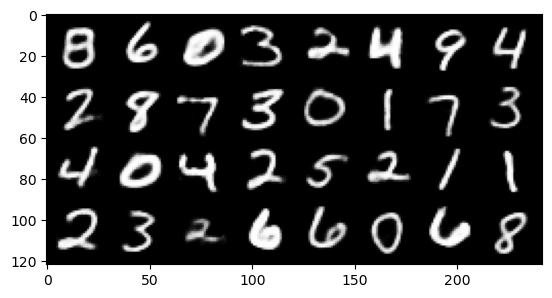

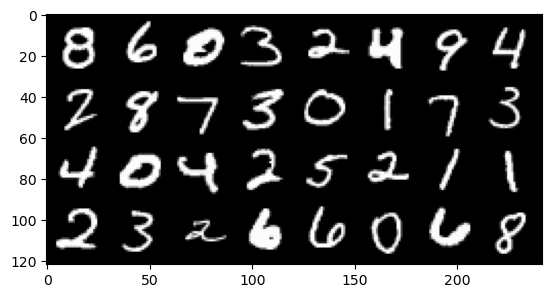

In [8]:
vae_model = VariationalAutoEncoder(hidden_dim=16)
optimizer = optim.Adam(vae_model.parameters(), lr=0.001)
criterion = vae_loss
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loss, test_loss = vae_model.train_model(train_dl, test_dl, optimizer, criterion, device, epochs=20, lr=0.001)

print("==========Reconstruction of images from test set==========")
display_reconstructions(vae_model, test_dl, device)